<a href="https://colab.research.google.com/github/wrttnwrd/GPlus-Eval---Public2/blob/master/Screaming_Frog_Vector_Embeddings_Use_Cases_(Public).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python code for the Use Cases for Vectorizing the Web with Screaming Frog article
[Read the Article](https://)
[Get the custom JavaScript functions](https://)
Note: You will liekly need to update the column names in the dataframes based on what you name your embeddings columns in Screaming Frog.

In [ ]:
!pip install scann openai hdbscan matplotlib scikit-learn bertopic bertopic[visualization]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
from IPython.display import clear_output
from IPython.display import display
import numpy as np
import pandas as pd
import scann
import openai
import pickle
import os
import re
from datetime import datetime
import hdbscan
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.representation import OpenAI

# Uncomment if you want to save your SCaNN indices
# Create the directory for the SCaNN index if it does not exist
#index_directory = 'scann_indices'
#if not os.path.exists(index_directory):
#    os.makedirs(index_directory)


openai.api_key = '[YOUR OPENAI API KEY HERE]' # Add this before you dod anything

# Load and Prepare Embeddings
Convert strings to floats

In [ ]:
def read_file(data_path, file_type):
  match file_type:
    case 'CSV':
      result = pd.read_csv(data_path, encoding = "ISO-8859-1")
    case 'Excel':
      result = pd.read_excel(data_path, engine = 'openpyxl')
    case 'TSV':
      try:
        print('Assuming Excel-exported CSV\nUsing UTF-16 encoding\nDefine separator as tab')
        result = pd.read_csv(data_path, sep = '\t', encoding = 'utf-16')
      except:
        result = pd.read_csv(data_path)

  return result

In [ ]:
data_path = '[Your Screaming Frog Export with Embeddings here]' # @param {'type': 'string'}
# @markdown Insert the name of the column in your dataset that contains your embeddings, or type 'None' if there is no column name:
embeddings_column = 'The name of your Embeddings Column Here' # @param {'type': 'string'}
# @markdown Select your input file format:
# file_type = 'CSV' # @param ['CSV', 'Excel', 'TSV'] {'type': 'string'}

new_float_col = '{}ConvertedFloats'.format(embeddings_column)

Build Document SCaNN Index

In [ ]:
import re
def scann_search(dataset:np.ndarray, queries: np.ndarray, n_neighbors = 10, distance_measure = "dot_product", num_leaves = 500, num_leaves_to_search = 100):
  normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]

  searcher = scann.scann_ops_pybind.builder(normalized_dataset, n_neighbors, distance_measure).tree(
      num_leaves=num_leaves, num_leaves_to_search=num_leaves_to_search, training_sample_size=250000).score_ah(
      2, anisotropic_quantization_threshold=0.2).reorder(100).build()

  return searcher


def convert_scann_arrays_to_urls(arrays: np.array, df: pd.DataFrame, column):
    results = []
    for arr in arrays:
      results.append(df.iloc[arr.flatten()][column].tolist())
    return results

siteDf = read_file(data_path, 'Excel')
siteDf = siteDf[siteDf[embeddings_column].isna() == False]
siteDf = siteDf[~siteDf[embeddings_column].str.contains('error')]
siteDf[new_float_col] = siteDf[embeddings_column].str.split(',')

siteDf[new_float_col] = siteDf[new_float_col].apply(lambda x: np.array(x, dtype = float))
siteDf['EmbeddingLength'] = siteDf[new_float_col].apply(lambda x: x.size)

if siteDf['EmbeddingLength'].unique().size == 1:
  d = siteDf['EmbeddingLength'].unique() #Number of dimensions for each value
else:
  print('Dimensionality reduction required to make all arrays the same size.')

dataset = np.vstack(siteDf[new_float_col].values) #Stacking all individual embeddings vertically into matrix
queries = dataset

siteSearcher = scann_search(dataset, queries)

neighbors, distances = siteSearcher.search_batched(queries, leaves_to_search = 150)

siteDf['ScannNearestNeighbors'] = convert_scann_arrays_to_urls(neighbors, siteDf, 'Address')
siteDf['ScannNearestNeighbors'] = siteDf['ScannNearestNeighbors'].apply(lambda x: x[2:])

display(siteDf)

# Uncomment if you want to save your index to use later
#index_directory = 'scann_indices/site_scann_index'
#if not os.path.exists(index_directory):
#    os.makedirs(index_directory)

#siteSearcher.serialize(index_directory)

,Address,Content Type,Status Code,Status,Indexability,Indexability Status,Title 1,Title 1 Length,Title 1 Pixel Width,Title 2,...,Clicks,Impressions,CTR,Position,Mobile Alternate Link,URL Encoded Address,Crawl Timestamp,OpenAI Embeddings 1ConvertedFloats,EmbeddingLength,ScannNearestNeighbors
0,https://ipullrank.com/google-search-generative...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,The New Google Search Generative Experience ft...,61,578,NaN,...,0.0,677.0,0.0000,34.55,NaN,https://ipullrank.com/google-search-generative...,2024-05-04 16:09:02,"[0.01581652, 0.007096346, -0.012709454, 0.0281...",1536,[https://ipullrank.com/the-scary-potential-of-...
1,https://ipullrank.com/reasons-you-need-a-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Reasons Why You Need a Content Audit - iPullRank,48,453,NaN,...,0.0,101.0,0.0000,45.90,NaN,https://ipullrank.com/reasons-you-need-a-conte...,2024-05-04 15:57:50,"[0.025885167, 0.036149975, -0.0042432984, 0.01...",1536,[https://ipullrank.com/how-to-measure-and-fix-...
2,https://ipullrank.com/rankable-ep-47-how-to-pr...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Rankable Ep.47 - How to Produce a Quality B2B ...,65,594,NaN,...,0.0,1.0,0.0000,85.00,NaN,https://ipullrank.com/rankable-ep-47-how-to-pr...,2024-05-04 17:05:19,"[0.012935678, 0.0012691639, -0.026017446, 0.02...",1536,[https://ipullrank.com/rankable-ep-43-why-seo-...
3,https://ipullrank.com/dr-epstein-you-dont-unde...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,"Dr. Epstein, You Don’t Understand How Search E...",69,635,NaN,...,3.0,83.0,0.0361,31.67,NaN,https://ipullrank.com/dr-epstein-you-dont-unde...,2024-05-04 17:20:41,"[0.031985838, 0.009701866, -0.023860525, 0.041...",1536,[https://ipullrank.com/why-google-search-conso...
4,https://ipullrank.com/guide-to-strategic-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Guide to Building a Strategic Content Distribu...,67,581,NaN,...,0.0,11.0,0.0000,65.36,NaN,https://ipullrank.com/guide-to-strategic-conte...,2024-05-04 16:28:04,"[0.04240207, 0.021339785, 0.006278448, 0.01261...",1536,[https://ipullrank.com/why-good-companies-make...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,https://ipullrank.com/resources/guides-ebooks/...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Basics Of Machine Learning for Marketers - iPu...,52,473,NaN,...,0.0,4.0,0.0000,25.25,NaN,https://ipullrank.com/resources/guides-ebooks/...,2024-05-04 15:37:27,"[-0.008349392, 0.019562522, -0.0029003315, -0....",1536,[https://ipullrank.com/resources/guides-ebooks...
715,https://ipullrank.com/seo-agency-vs-full-time-...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,SEO Agency vs. In-House SEO: Pros and Cons - i...,54,501,NaN,...,0.0,347.0,0.0000,65.99,NaN,https://ipullrank.com/seo-agency-vs-full-time-...,2024-05-04 15:39:23,"[0.01962584, 0.01806868, -0.000810583, 0.03706...",1536,[https://ipullrank.com/hidden-opportunities-of...
716,https://ipullrank.com/boring-generative-ai-pre...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Your 2024 Boring (and Ridiculous) Generative A...,65,591,NaN,...,1.0,94.0,0.0106,28.88,NaN,https://ipullrank.com/boring-generative-ai-pre...,2024-05-04 15:55:04,"[0.019888666, 0.0008121713, -0.015137653, 0.02...",1536,[https://ipullrank.com/optimize-content-for-sg...
717,https://ipullrank.com/how-to-inject-search-vol...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,How To Inject Search Volume and CPC to Google ...,66,638,NaN,...,6.0,402.0,0.0149,51.35,NaN,https://ipullrank.com/how-to-inject-search-vol...,2024-05-04 15:55:10,"[0.010199954, 0.036009785, 0.014961812, 0.0334...",1536,[https://ipullrank.com/why-google-search-conso...


## Vectorize Keyword List
Using a keyword list from Semrush's Organic Research export.

In [ ]:
# Function to get embeddings and flatten them for SCANN
def get_openai_embeddings(keyword):
    response = openai.embeddings.create(
        input=keyword,
        model="text-embedding-3-small"  # Make sure to use the same embeddings as Screaming Frog
    )
    # Extract and flatten the embedding
    embedding_vector = response.data[0].embedding
    return np.array(embedding_vector).flatten()

semrushFile = '[YOUR SEMRUSH ORGANIC RESEARCH EXPORT HERE]'
keywordDf = read_file(semrushFile, 'CSV')
display(keywordDf)

# Loop through the DataFrame and get embeddings for each keyword
embeddings = []
for keyword in keywordDf['Keyword']:
    embeddings.append(get_openai_embeddings(keyword))

keywordDf['embeddings'] = embeddings

# Create a temporary DataFrame for Excel output with embeddings converted to strings
tempDf = keywordDf.copy()
tempDf['embeddings'] = tempDf['embeddings'].apply(lambda x: str(x))
tempDf.to_excel('semrush-embeddings.xlsx', index=False) # Save with embeddings as strings

# Display the updated DataFrame
print(keywordDf.head())

embeddings_matrix = np.vstack(keywordDf['embeddings'])

keywordSearcher = scann.scann_ops_pybind.builder(embeddings_matrix, 10, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

# Uncomment if you want to save your index to use later
#index_directory = 'scann_indices/keyword_scann_index'
#if not os.path.exists(index_directory):
#    os.makedirs(index_directory)
#keywordSearcher.serialize(index_directory+'/keyword_scann_index')

,Keyword,Position,Previous position,Search Volume,Keyword Difficulty,CPC,URL,Traffic,Traffic (%),Traffic Cost,Competition,Number of Results,Trends,Timestamp,SERP Features by Keyword,Keyword Intents,Position Type
0,parito,1,1,2400,11,1.63,https://ipullrank.com/tools/parito/,595,36.72,970.0,0.01,0,"[10,10,10,15,10,13,13,13,100,66,66,81]",2022-04-26,"Sitelinks, FAQ",informational,Organic
1,paritos,4,3,2900,19,0.00,https://ipullrank.com/tools/parito/,188,11.60,0.0,0.00,87,"[100,100,100,100,100,7,7,3,0,0,0,0]",2022-04-26,"Image pack, Sitelinks, Video",informational,Organic
2,ipullrank,1,1,210,45,6.16,https://ipullrank.com/,168,10.37,1034.0,0.05,68,"[53,100,65,43,65,100,53,100,53,43,43,81]",2022-03-30,"Knowledge panel, Image pack, Sitelinks, Review...",navigational,Organic
3,michael king ipullrank,1,1,50,23,0.00,https://ipullrank.com/about-ipullrank,40,2.46,0.0,0.00,241000,"[100,64,17,17,17,17,17,17,17,17,17,17]",2022-04-12,"Image pack, Reviews, Tweet, Video Carousel",informational,Organic
4,how does a chatbot use machine learning,10,8,1600,50,0.00,https://ipullrank.com/resources/guides-ebooks/...,35,2.16,0.0,0.00,10600000,"[100,0]",2022-04-20,"Reviews, Featured snippet, Video Carousel, Peo...",informational,Organic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,cls issue more than 0.1,82,73,210,34,0.00,https://ipullrank.com/what-are-core-web-vitals...,0,0.00,0.0,0.00,2000000,"[0,100,1,0,1,0,0,1]",2022-04-23,"Sitelinks, Video, People also ask",informational,Organic
3040,google gsc,22,0,90,90,0.00,https://ipullrank.com/the-beginners-guide-to-g...,0,0.00,0.0,0.00,18400000,"[4,9,9,9,9,19,100,4,100,52,80,80]",2022-04-22,"Knowledge panel, Reviews, Video, People also ask",navigational,Organic
3041,nurture email,73,0,110,48,9.76,https://ipullrank.com/10-data-driven-steps-to-...,0,0.00,0.0,0.24,133000000,"[100,100,80,100,19,19,9,33,23,14,19,23]",2022-04-30,"Sitelinks, Featured snippet, Video Carousel, P...",informational,Organic
3042,fitbit disclaimer,17,15,50,59,0.00,https://ipullrank.com/content-strategy-for-fitbit,0,0.00,0.0,0.11,35600000,"[11,100,0,11,11,11,11,11,11,11,11,11]",2022-04-05,"Reviews, Video, People also ask","navigational, transactional",Organic


                                   Keyword  Position  Previous position  \
0                                   parito         1                  1   
1                                  paritos         4                  3   
2                                ipullrank         1                  1   
3                   michael king ipullrank         1                  1   
4  how does a chatbot use machine learning        10                  8   

   Search Volume  Keyword Difficulty   CPC  \
0           2400                  11  1.63   
1           2900                  19  0.00   
2            210                  45  6.16   
3             50                  23  0.00   
4           1600                  50  0.00   

                                                 URL  Traffic  Traffic (%)  \
0                https://ipullrank.com/tools/parito/      595        36.72   
1                https://ipullrank.com/tools/parito/      188        11.60   
2                             https://

# Keyword Mapping

In [ ]:
# Search siteDf for keywords, return 1 neighbor

queries = np.vstack(keywordDf['embeddings'].values)

kwSearcher = scann_search(dataset, queries) # dataset is the same as before

nearest_neighbors = kwSearcher.search_batched(queries, final_num_neighbors=1)

matched_urls = convert_scann_arrays_to_urls(nearest_neighbors, siteDf, 'Address')

keywordDf['BestMatchURL'] = convert_scann_arrays_to_urls(neighbors, siteDf, 'Address')
keywordDf['BestMatchURL'] = keywordDf['BestMatchURL'].apply(lambda x: x[:1][0])
display(keywordDf)


# Create a temporary DataFrame for Excel output with embeddings converted to strings
tempDf = keywordDf.copy()
tempDf['embeddings'] = tempDf['embeddings'].apply(lambda x: str(x))
tempDf.to_excel('keyword-mapping.xlsx', index=False) # Save with embeddings as strings



,Keyword,Position,Previous position,Search Volume,Keyword Difficulty,CPC,URL,Traffic,Traffic (%),Traffic Cost,Competition,Number of Results,Trends,Timestamp,SERP Features by Keyword,Keyword Intents,Position Type,embeddings,BestMatchURL
0,parito,1,1,2400,11,1.63,https://ipullrank.com/tools/parito/,595,36.72,970.0,0.01,0,"[10,10,10,15,10,13,13,13,100,66,66,81]",2022-04-26,"Sitelinks, FAQ",informational,Organic,"[0.008845677599310875, -0.019211098551750183, ...",https://ipullrank.com/people-supporting-seos
1,paritos,4,3,2900,19,0.00,https://ipullrank.com/tools/parito/,188,11.60,0.0,0.00,87,"[100,100,100,100,100,7,7,3,0,0,0,0]",2022-04-26,"Image pack, Sitelinks, Video",informational,Organic,"[0.021161237731575966, 0.013392913155257702, 0...",https://ipullrank.com/people-supporting-seos
2,ipullrank,1,1,210,45,6.16,https://ipullrank.com/,168,10.37,1034.0,0.05,68,"[53,100,65,43,65,100,53,100,53,43,43,81]",2022-03-30,"Knowledge panel, Image pack, Sitelinks, Review...",navigational,Organic,"[-0.025947729125618935, -0.0063078212551772594...",https://ipullrank.com/tools/raggle/
3,michael king ipullrank,1,1,50,23,0.00,https://ipullrank.com/about-ipullrank,40,2.46,0.0,0.00,241000,"[100,64,17,17,17,17,17,17,17,17,17,17]",2022-04-12,"Image pack, Reviews, Tweet, Video Carousel",informational,Organic,"[-0.018118655309081078, 0.008866247721016407, ...",https://ipullrank.com/resources/best-of-mike-king
4,how does a chatbot use machine learning,10,8,1600,50,0.00,https://ipullrank.com/resources/guides-ebooks/...,35,2.16,0.0,0.00,10600000,"[100,0]",2022-04-20,"Reviews, Featured snippet, Video Carousel, Peo...",informational,Organic,"[-0.009844654239714146, -0.006732553243637085,...",https://ipullrank.com/resources/guides-ebooks/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,cls issue more than 0.1,82,73,210,34,0.00,https://ipullrank.com/what-are-core-web-vitals...,0,0.00,0.0,0.00,2000000,"[0,100,1,0,1,0,0,1]",2022-04-23,"Sitelinks, Video, People also ask",informational,Organic,"[-0.033539775758981705, 0.0007994032348506153,...",https://ipullrank.com/tools/parito/
3040,google gsc,22,0,90,90,0.00,https://ipullrank.com/the-beginners-guide-to-g...,0,0.00,0.0,0.00,18400000,"[4,9,9,9,9,19,100,4,100,52,80,80]",2022-04-22,"Knowledge panel, Reviews, Video, People also ask",navigational,Organic,"[-0.014425395987927914, 0.03262566402554512, 0...",https://ipullrank.com/category/sge
3041,nurture email,73,0,110,48,9.76,https://ipullrank.com/10-data-driven-steps-to-...,0,0.00,0.0,0.24,133000000,"[100,100,80,100,19,19,9,33,23,14,19,23]",2022-04-30,"Sitelinks, Featured snippet, Video Carousel, P...",informational,Organic,"[0.008941811509430408, 0.021838035434484482, -...",https://ipullrank.com/10-data-driven-steps-to-...
3042,fitbit disclaimer,17,15,50,59,0.00,https://ipullrank.com/content-strategy-for-fitbit,0,0.00,0.0,0.11,35600000,"[11,100,0,11,11,11,11,11,11,11,11,11]",2022-04-05,"Reviews, Video, People also ask","navigational, transactional",Organic,"[0.010954041965305805, -0.024963604286313057, ...",https://pages.ipullrank.com/privacy-policy


# Keyword Relevance

In [ ]:
# Function to normalize embeddings
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return (embeddings / norms).tolist()  # Normalize and convert to list

# Normalize the embeddings and convert them to lists for DataFrame storage
keywordDf['NormalizedEmbeddings'] = normalize_embeddings(np.vstack(keywordDf['embeddings'].values))
siteDf['NormalizedEmbeddings'] = normalize_embeddings(np.vstack(siteDf[new_float_col].values))

# Function to calculate cosine similarity
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2)

# Initialize a list to store cosine similarity results
cosine_similarities = []
relevance_values = []

# Loop through each keyword to calculate cosine similarity with its corresponding URL in siteDf
for index, row in keywordDf.iterrows():
    keyword_url = row['URL']
    keyword_embedding = row['NormalizedEmbeddings']  # This is now a list

    # Find the corresponding URL in siteDf
    if keyword_url in siteDf['Address'].values:
        # Get the embedding for the matching URL, which is also stored as a list
        url_embedding = siteDf.loc[siteDf['Address'] == keyword_url, 'NormalizedEmbeddings'].iloc[0]
        # Convert list to numpy array for calculation
        similarity = cosine_similarity(np.array(keyword_embedding), np.array(url_embedding))
        relevance = similarity * 100
    else:
        similarity = None  # Set similarity to None if no matching URL is found
        relevance = None

    cosine_similarities.append(similarity)
    relevance_values.append(relevance)

# Store the cosine similarities in the keywordDf
keywordDf['CosineSimilarity'] = cosine_similarities
keywordDf['Relevance'] = relevance_values


# Display or use the updated DataFrame
print(keywordDf[['Keyword', 'URL', 'CosineSimilarity','Relevance']])

keywordDf.to_excel('keyword-relevance.xlsx')

                                      Keyword  \
0                                      parito   
1                                     paritos   
2                                   ipullrank   
3                      michael king ipullrank   
4     how does a chatbot use machine learning   
...                                       ...   
3039                  cls issue more than 0.1   
3040                               google gsc   
3041                            nurture email   
3042                        fitbit disclaimer   
3043                                    tdidf   

                                                    URL  CosineSimilarity  \
0                   https://ipullrank.com/tools/parito/          0.151173   
1                   https://ipullrank.com/tools/parito/          0.213691   
2                                https://ipullrank.com/          0.306037   
3                 https://ipullrank.com/about-ipullrank               NaN   
4     https://ipullrank.co

# Internal Link Mapping (Keyword to Page)

In [ ]:
# Search siteDf for keywords, return 10 neighbors per keyword

queries = np.vstack(keywordDf['embeddings'].values) #Stacking all individual embeddings vertically into matrix

kwSearcher = scann_search(dataset, queries) # dataset is the same as before
neighbors, distances = siteSearcher.search_batched(queries, leaves_to_search = 150)

nearest_neighbors = kwSearcher.search_batched(queries, final_num_neighbors=5)

matched_urls = convert_scann_arrays_to_urls(nearest_neighbors, siteDf, 'Address')

keywordDf['InternalLinkSuggestions'] = convert_scann_arrays_to_urls(neighbors, siteDf, 'Address')
keywordDf['InternalLinkSuggestions'] = keywordDf['InternalLinkSuggestions'].apply(lambda x: x[1:])
display(keywordDf)

# Create a temporary DataFrame for Excel output with embeddings converted to strings
tempDf = keywordDf.copy()
tempDf['embeddings'] = tempDf['embeddings'].apply(lambda x: str(x))
tempDf.to_excel('keyword-internal-link-mapping.xlsx', index=False) # Save with embeddings as strings

# Search siteDf for pages, return 10 neighbors per page

# dump to Excel sheet

NameError: name 'keywordDf' is not defined

# Internal Link Mapping (Page to Page)

In [ ]:
queries = dataset

siteSearcher = scann_search(dataset, queries)

neighbors, distances = siteSearcher.search_batched(queries, leaves_to_search = 150)

nearest_neighbors = siteSearcher.search_batched(queries, final_num_neighbors=10)

matched_urls = convert_scann_arrays_to_urls(nearest_neighbors, siteDf, 'Address')

siteDf['PageToPageLinkMapping'] = convert_scann_arrays_to_urls(neighbors, siteDf, 'Address')
siteDf['PageToPageLinkMapping'] = siteDf['PageToPageLinkMapping'].apply(lambda x: x[2:])
display(siteDf)
siteDf.to_excel('page-to-page-link-mapping.xlsx')


,Address,Content Type,Status Code,Status,Indexability,Indexability Status,Title 1,Title 1 Length,Title 1 Pixel Width,Title 2,...,Impressions,CTR,Position,Mobile Alternate Link,URL Encoded Address,Crawl Timestamp,OpenAI Embeddings 1ConvertedFloats,EmbeddingLength,ScannNearestNeighbors,PageToPageLinkMapping
0,https://ipullrank.com/google-search-generative...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,The New Google Search Generative Experience ft...,61,578,NaN,...,677.0,0.0000,34.55,NaN,https://ipullrank.com/google-search-generative...,2024-05-04 16:09:02,"[0.01581652, 0.007096346, -0.012709454, 0.0281...",1536,[https://ipullrank.com/the-scary-potential-of-...,[https://ipullrank.com/the-scary-potential-of-...
1,https://ipullrank.com/reasons-you-need-a-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Reasons Why You Need a Content Audit - iPullRank,48,453,NaN,...,101.0,0.0000,45.90,NaN,https://ipullrank.com/reasons-you-need-a-conte...,2024-05-04 15:57:50,"[0.025885167, 0.036149975, -0.0042432984, 0.01...",1536,[https://ipullrank.com/how-to-measure-and-fix-...,[https://ipullrank.com/how-to-measure-and-fix-...
2,https://ipullrank.com/rankable-ep-47-how-to-pr...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Rankable Ep.47 - How to Produce a Quality B2B ...,65,594,NaN,...,1.0,0.0000,85.00,NaN,https://ipullrank.com/rankable-ep-47-how-to-pr...,2024-05-04 17:05:19,"[0.012935678, 0.0012691639, -0.026017446, 0.02...",1536,[https://ipullrank.com/rankable-ep-43-why-seo-...,[https://ipullrank.com/rankable-ep-43-why-seo-...
3,https://ipullrank.com/dr-epstein-you-dont-unde...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,"Dr. Epstein, You Don’t Understand How Search E...",69,635,NaN,...,83.0,0.0361,31.67,NaN,https://ipullrank.com/dr-epstein-you-dont-unde...,2024-05-04 17:20:41,"[0.031985838, 0.009701866, -0.023860525, 0.041...",1536,[https://ipullrank.com/why-google-search-conso...,[https://ipullrank.com/why-google-search-conso...
4,https://ipullrank.com/guide-to-strategic-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Guide to Building a Strategic Content Distribu...,67,581,NaN,...,11.0,0.0000,65.36,NaN,https://ipullrank.com/guide-to-strategic-conte...,2024-05-04 16:28:04,"[0.04240207, 0.021339785, 0.006278448, 0.01261...",1536,[https://ipullrank.com/why-good-companies-make...,[https://ipullrank.com/why-good-companies-make...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,https://ipullrank.com/resources/guides-ebooks/...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Basics Of Machine Learning for Marketers - iPu...,52,473,NaN,...,4.0,0.0000,25.25,NaN,https://ipullrank.com/resources/guides-ebooks/...,2024-05-04 15:37:27,"[-0.008349392, 0.019562522, -0.0029003315, -0....",1536,[https://ipullrank.com/resources/guides-ebooks...,[https://ipullrank.com/resources/guides-ebooks...
715,https://ipullrank.com/seo-agency-vs-full-time-...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,SEO Agency vs. In-House SEO: Pros and Cons - i...,54,501,NaN,...,347.0,0.0000,65.99,NaN,https://ipullrank.com/seo-agency-vs-full-time-...,2024-05-04 15:39:23,"[0.01962584, 0.01806868, -0.000810583, 0.03706...",1536,[https://ipullrank.com/hidden-opportunities-of...,[https://ipullrank.com/hidden-opportunities-of...
716,https://ipullrank.com/boring-generative-ai-pre...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Your 2024 Boring (and Ridiculous) Generative A...,65,591,NaN,...,94.0,0.0106,28.88,NaN,https://ipullrank.com/boring-generative-ai-pre...,2024-05-04 15:55:04,"[0.019888666, 0.0008121713, -0.015137653, 0.02...",1536,[https://ipullrank.com/optimize-content-for-sg...,[https://ipullrank.com/optimize-content-for-sg...
717,https://ipullrank.com/how-to-inject-search-vol...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,How To Inject Search Volume and CPC to Google ...,66,638,NaN,...,402.0,0.0149,51.35,NaN,https://ipullrank.com/how-to-inject-search-vol...,2024-05-04 15:55:10,"[0.010199954, 0.036009785, 0.0149

# Redirect Mapping

In [ ]:
migratingSiteDf = read_file('migrating-site.xlsx', 'Excel')
migratingSiteDf = migratingSiteDf[migratingSiteDf['OpenAIEmbeddings'].isna() == False]
migratingSiteDf = migratingSiteDf[~migratingSiteDf['OpenAIEmbeddings'].str.contains('error')]
migratingSiteDf['OpenAIEmbeddingsFloats'] = migratingSiteDf['OpenAIEmbeddings'].str.split(',')

migratingSiteDf['OpenAIEmbeddingsFloats'] = migratingSiteDf['OpenAIEmbeddingsFloats'].apply(lambda x: np.array(x, dtype = float))

queries = np.vstack(migratingSiteDf['OpenAIEmbeddingsFloats'].values) #Stacking all individual embeddings vertically into matrix

migrationSearcher = scann_search(dataset, queries) # dataset is the same as before
neighbors, distances = migrationSearcher.search_batched(queries, leaves_to_search = 150)

nearest_neighbors = migrationSearcher.search_batched(queries, final_num_neighbors=1)

migratingSiteDf['MigrationTargetSuggestions'] = convert_scann_arrays_to_urls(neighbors, siteDf, 'Address')
migratingSiteDf['MigrationTargetSuggestions'] = migratingSiteDf['MigrationTargetSuggestions'].apply(lambda x: x[:1][0])

display(migratingSiteDf)
migratingSiteDf.to_excel('migration-recommendations.xlsx')



,Address,Status Code,Status,OpenAIEmbeddings,OpenAIEmbeddingsFloats,MigrationTargetSuggestions
0,https://www.portent.com/blog/content/5-image-e...,200,NaN,"0.0047567463,0.035463586,-0.059455473,0.001425...","[0.0047567463, 0.035463586, -0.059455473, 0.00...",https://ipullrank.com/what-it-takes-to-get-rem...
1,https://www.portent.com/blog/paid-social/how-i...,200,NaN,"-0.00041686013,0.023678169,-0.04332776,0.02830...","[-0.00041686013, 0.023678169, -0.04332776, 0.0...",https://ipullrank.com/open-graph-helper
2,https://www.portent.com/blog/paid-social/how-t...,200,NaN,"0.00023106295,0.008294091,-0.04951163,0.018224...","[0.00023106295, 0.008294091, -0.04951163, 0.01...",https://ipullrank.com/open-graph-helper
3,https://www.portent.com/blog/seo/featured-snip...,200,NaN,"-0.0054706978,0.018562476333333335,0.003371462...","[-0.0054706978, 0.018562476333333335, 0.003371...",https://ipullrank.com/how-to-write-content-to-...
4,https://www.portent.com/blog/analytics/gtm-gdp...,200,NaN,"-0.007363605499999999,0.024907513,-0.015395383...","[-0.007363605499999999, 0.024907513, -0.015395...",https://ipullrank.com/your-analytics-data-isnt...
...,...,...,...,...,...,...
952,https://www.portent.com/blog/paid-social/optim...,200,NaN,"0.013056387,0.0027705906,-0.012851036,0.003052...","[0.013056387, 0.0027705906, -0.012851036, 0.00...",https://ipullrank.com/rankable-how-to-approach...
953,https://www.portent.com/webinar/internet-marke...,200,NaN,"0.0016132692,0.04252789,-0.013630735,-0.015352...","[0.0016132692, 0.04252789, -0.013630735, -0.01...",https://ipullrank.com/resources/webinars/autom...
954,https://www.portent.com/ebook/ppc/mobile-ppc-a...,200,NaN,"0.035336956,0.033939604,-0.013133793,0.0073764...","[0.035336956, 0.033939604, -0.013133793, 0.007...",https://ipullrank.com/the-ultimate-list-of-eve...
955,https://www.portent.com/blog/paid-social/dunba...,200,NaN,"-0.026642868,0.016975267,-0.03964693,0.0319161...","[-0.026642868, 0.016975267, -0.03964693, 0.031...",https://ipullrank.com/open-graph-helper


# Link Building Target Identification

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load the DataFrame
linkProspectsDf = pd.read_excel('link-prospects.xlsx')
linkProspectsDf = linkProspectsDf[linkProspectsDf['OpenAI Embeddings Long Inputs 1'].notna()]
linkProspectsDf = linkProspectsDf[~linkProspectsDf['OpenAI Embeddings Long Inputs 1'].str.contains('error|TypeError', regex=True)]

# Convert the string of numbers into a list of floats
def convert_embeddings(embedding_str):
    try:
        # Split the string into a list of strings, then convert each to float
        return np.array([float(num) for num in embedding_str.split(',')])
    except ValueError:
        # Return None or np.nan in case of conversion failure, which should be handled or filtered later
        return np.nan

linkProspectsDf['OpenAIEmbeddingsFloats'] = linkProspectsDf['OpenAI Embeddings Long Inputs 1'].apply(convert_embeddings)

# Remove rows where embeddings conversion failed (if any)
linkProspectsDf.dropna(subset=['OpenAIEmbeddingsFloats'], inplace=True)

# Normalize the embeddings
linkProspectsDf['normalized_embeddings'] = linkProspectsDf['OpenAIEmbeddingsFloats'].apply(lambda x: x / np.linalg.norm(x))
siteDf['normalized_embeddings'] = siteDf[new_float_col].apply(lambda x: x / np.linalg.norm(x))

# Specific URL to search for
specific_url = 'https://ipullrank.com/enterprise-seo'  # Change this to your specific URL

# Retrieve the normalized embedding for the specific URL
specific_embedding = siteDf[siteDf['Address'] == specific_url]['normalized_embeddings'].values[0]

# Prepare the embeddings array from the second dataframe
embeddings2 = np.stack(linkProspectsDf['normalized_embeddings'].values)

# Calculate cosine similarity
cosine_similarity_scores = 1 - cdist([specific_embedding], embeddings2, 'cosine')[0]

# Create a dataframe to store the results
results = pd.DataFrame({
    'Search Address': specific_url,
    'Target Address': linkProspectsDf['Address'],
    'Cosine Similarity Score': cosine_similarity_scores
})

# Optionally, sort the results by scores
results = results.sort_values(by='Cosine Similarity Score', ascending=False)
results.to_excel('link-prospect-relevance.xlsx')
display(results)


,Search Address,Target Address,Cosine Similarity Score
4,https://ipullrank.com/enterprise-seo,https://www.upsqode.com/blog/enterprise-seo/,0.827209
73,https://ipullrank.com/enterprise-seo,https://neo360.digital/blog/enterprise-seo-str...,0.779193
79,https://ipullrank.com/enterprise-seo,https://itxitpro.com/blog/key-trends-in-enterp...,0.771589
17,https://ipullrank.com/enterprise-seo,https://www.nexmind.ai/enterprise-seo-platform/,0.736555
97,https://ipullrank.com/enterprise-seo,https://claritydigital.agency/whats-the-role-o...,0.681680
...,...,...,...
22,https://ipullrank.com/enterprise-seo,https://www.lightonseo.com/voir-son-site-comme...,0.304697
14,https://ipullrank.com/enterprise-seo,https://www.nutripeople.org/minimum-width-smar...,0.283458
94,https://ipullrank.com/enterprise-seo,https://cultinfos.com/social/196227.html,0.237709
110,https://ipullrank.com/enterprise-seo,http://www.tradfrance.com/blizzard-404-k.html,0.090725


# Page Type Determination

In [ ]:
# count unique on PageType embeddings

# Content Clustering

Starting the topic modeling process for keywords...

Reducing dimensions for visualization...


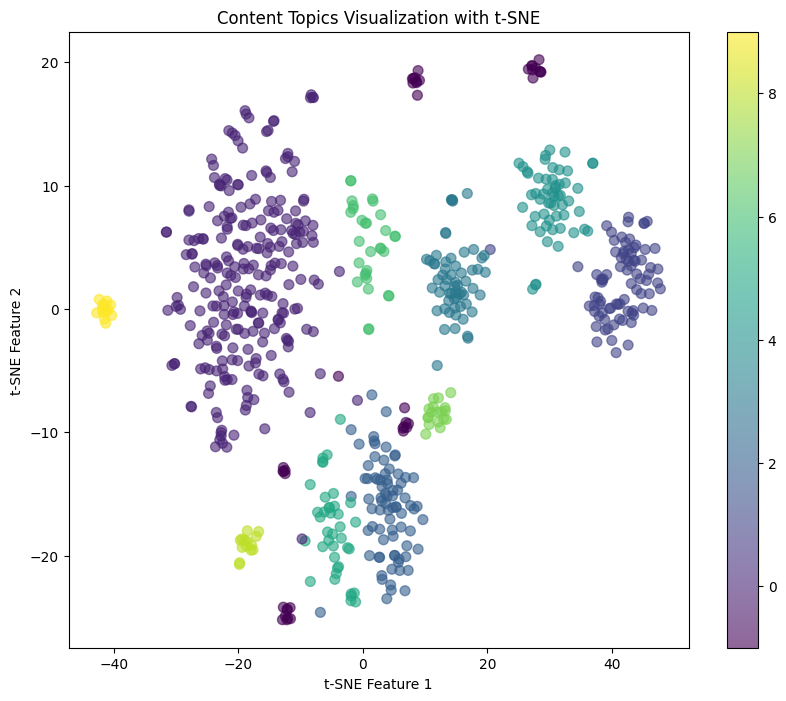

Visualizing topic probabilities...


Visualizing intertopic distance map...


Visualizing hierarchical clustering...


,Address,Content Type,Status Code_x,Status_x,Indexability,Indexability Status,Title 1,Title 1 Length,Title 1 Pixel Width,Title 2,...,OpenAI Embeddings 1ConvertedFloats,EmbeddingLength,ScannNearestNeighbors,NormalizedEmbeddings,PageToPageLinkMapping,Status Code_y,Status_y,Page Content,topic,topic_name
0,https://ipullrank.com/google-search-generative...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,The New Google Search Generative Experience ft...,61,578,NaN,...,"[0.01581652, 0.007096346, -0.012709454, 0.0281...",1536,[https://ipullrank.com/the-scary-potential-of-...,"[0.01581651931862181, 0.007096345694288288, -0...",[https://ipullrank.com/the-scary-potential-of-...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,4,SEO Marketing PodcastGuild
1,https://ipullrank.com/reasons-you-need-a-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Reasons Why You Need a Content Audit - iPullRank,48,453,NaN,...,"[0.025885167, 0.036149975, -0.0042432984, 0.01...",1536,[https://ipullrank.com/how-to-measure-and-fix-...,"[0.025885168360003884, 0.03614997689931579, -0...",[https://ipullrank.com/how-to-measure-and-fix-...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,0,Search Engine Optimization (SEO) Strategies
2,https://ipullrank.com/rankable-ep-47-how-to-pr...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Rankable Ep.47 - How to Produce a Quality B2B ...,65,594,NaN,...,"[0.012935678, 0.0012691639, -0.026017446, 0.02...",1536,[https://ipullrank.com/rankable-ep-43-why-seo-...,"[0.012935677958160191, 0.0012691638958949522, ...",[https://ipullrank.com/rankable-ep-43-why-seo-...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,3,Digital Marketing Agency
3,https://ipullrank.com/dr-epstein-you-dont-unde...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,"Dr. Epstein, You Don’t Understand How Search E...",69,635,NaN,...,"[0.031985838, 0.009701866, -0.023860525, 0.041...",1536,[https://ipullrank.com/why-google-search-conso...,"[0.03198583865114205, 0.009701866197502811, -0...",[https://ipullrank.com/why-google-search-conso...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,0,Search Engine Optimization (SEO) Strategies
4,https://ipullrank.com/guide-to-strategic-conte...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Guide to Building a Strategic Content Distribu...,67,581,NaN,...,"[0.04240207, 0.021339785, 0.006278448, 0.01261...",1536,[https://ipullrank.com/why-good-companies-make...,"[0.04240206921359951, 0.021339784604226458, 0....",[https://ipullrank.com/why-good-companies-make...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,0,Search Engine Optimization (SEO) Strategies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,https://ipullrank.com/resources/guides-ebooks/...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Basics Of Machine Learning for Marketers - iPu...,52,473,NaN,...,"[-0.008349392, 0.019562522, -0.0029003315, -0....",1536,[https://ipullrank.com/resources/guides-ebooks...,"[-0.008349391964507047, 0.019562521916840447, ...",[https://ipullrank.com/resources/guides-ebooks...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,8,Machine Learning Models Analysis
677,https://ipullrank.com/seo-agency-vs-full-time-...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,SEO Agency vs. In-House SEO: Pros and Cons - i...,54,501,NaN,...,"[0.01962584, 0.01806868, -0.000810583, 0.03706...",1536,[https://ipullrank.com/hidden-opportunities-of...,"[0.019625840133627823, 0.018068680123025482, -...",[https://ipullrank.com/hidden-opportunities-of...,200,NaN,Menu\nHome\nContact Us\nEnterprise SEO\nServic...,0,Search Engine Optimization (SEO) Strategies
678,https://ipullrank.com/boring-generative-ai-pre...,text/html; charset=UTF-8,200,NaN,Indexable,NaN,Your 2024 Boring (and Ridiculous) Generative A...,65,591,NaN,...,"[0.019888666, 0.0008121713, -0.015137653, 0.02...",1536,[https://ipullrank.com/optimize-content-for-sg...,"[0.019888665710580837, 0.00081217128818

In [ ]:
# Content Clustering

def cluster_and_visualize_content(df, embeddings_col):
    print("Starting the topic modeling process for keywords...\n")

    # Prepare data
    df['Page Content'] = df['Page Content'].astype(str)
    keywords = df['Page Content'].tolist()
    embeddings = np.vstack(df[embeddings_col].tolist())  # Ensure embeddings are properly shaped
    embeddings = normalize(embeddings)  # Normalize embeddings for cosine similarity


    prompt = """
      I have topic that is described by the following keywords: [KEYWORDS]
      I am attempting to categorize this topic as part of 2-4 word taxonomy label that encapsulates all the keywords.
      Based on the above information, can you give a short taxonomy label of the topic? Just return the taxonomy label itself.
      """
    client = openai.OpenAI(api_key=openai.api_key)
    representation_model = OpenAI(client, model="gpt-3.5-turbo", prompt=prompt,chat=True)
    # Initialize BERTopic
    topic_model = BERTopic(representation_model=representation_model,calculate_probabilities=True)

    # Fit BERTopic
    topics, probabilities = topic_model.fit_transform(keywords, embeddings)
    df['topic'] = topics  # Adding topic numbers to the DataFrame

    # Visualize the topics with t-SNE
    print("Reducing dimensions for visualization...")
    tsne = TSNE(n_components=2, random_state=42, metric='euclidean')
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=topics, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar()
    plt.title('Content Topics Visualization with t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.show()

    # Probability distribution visualization
    min_probability = 0.01
    if any(probabilities[0] > min_probability):
        print("Visualizing topic probabilities...")
        fig = topic_model.visualize_distribution(probabilities[0], min_probability=min_probability)
        fig.show()
    else:
        print("No topic probabilities above the threshold to visualize.")

    # Intertopic distance map
    print("Visualizing intertopic distance map...")
    fig = topic_model.visualize_topics()
    fig.show()

    # Hierarchical clustering
    print("Visualizing hierarchical clustering...")
    fig = topic_model.visualize_hierarchy()
    fig.show()

    # Extract and name topics
    df['topic_name'] = df['topic'].apply(lambda x: topic_model.get_topic(x)[0][0] if topic_model.get_topic(x) else 'No dominant topic')

    # Display DataFrame with topic names
    display(df)

    # Export the DataFrame with topic labels
    df.to_excel('content-clusters-bertopic.xlsx', index=False)

pageContentDf = read_file('ipr-content.xlsx', 'Excel')

contentEmbeddingsDf = siteDf.merge(pageContentDf, on='Address', how='inner')

cluster_and_visualize_content(contentEmbeddingsDf, 'OpenAI Embeddings 1ConvertedFloats')